### Loading Libraries and Dataset

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from faker import Faker
import random
import re
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from category_encoders import BinaryEncoder

#pd.set_option("display.max_column", None)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the Dataset
df = pd.read_csv(r"C:\Users\hp\Downloads\WEEK 174 STATE LINELIST.csv")

In [3]:
# show distribution of target variable
df['CurrentARTStatus'].value_counts()

CurrentARTStatus
Active               73488
LTFU                 24183
Discontinued Care     7116
Transferred out       3168
Death                 2530
Name: count, dtype: int64

#### Data Anonymization

In [4]:
# Initialize faker function
fake = Faker()

In [5]:
def anonymize_data(df):
    ''' This function creates fake observations and apply to respective variable names'''
    df['Patient_Name'] = df['Patient_Name'].apply(lambda x: fake.name())
    df['ART_ID'] = df['ART_ID'].apply(lambda x: fake.phone_number())
    df['Patient_Address'] = df['Patient_Address'].apply(lambda x: fake.address().replace('\n', ' '))
    df['Patient_LGA'] = df['Patient_LGA'].apply(lambda x: fake.address().replace('\n', ' '))
    return df

anonymized_df = anonymize_data(df)

In [7]:
data = anonymized_df

### EDA and Data Cleaning

In [8]:
def clean_data(data):
    ''' This function cleans some of the basic irregularities in the dataset such as datatype structuring, filling null values'''
    # drop irrelevant columns 
    data.drop(['Age_in_months', 'setting', 'DOB', 'Facility_Name', 
               'IP', 'Datim_Code', 'HospitalNo','Patient_LGA',
               'Patient_State', 'State', 'Phone_No', 'Patient_Name', 
               'Patient_Address'], axis = 1, inplace = True)
    
    # convert selected columns to datetime datatype
    conv_to_datetime = ['EnrollmentDate', 'ART_Start_Date', 'ViralLoadReportedDate', 'Clinic_Visit_Lastdate', 'Pharmacy_LastPickupdate',
                        'stamp_date', 'DateofCurrentViralLoad', 'ViralLoadReportedDate', 'LastDateOfSampleCollection', 'TBStatusDate',
                        'INHStartDate',	'INHStopDate',	'LastINHDispensedDate',	'TBTreatmentStartDate',	'TBTreatmentStopDate',	
                        'OTZStartDate',	'OTZStopDate', 'DateofFirstDTGPickup', 'Termination_Date', 'Next_Visit_Date',	
                        'Next_Ap_by_pharmPill',	'Next_Ap_by_careCard', 'Biometric_date', 'Date_Generated', 'CurrentHeightDate', 'CurrentWeightDate']
    for col in conv_to_datetime:
        data[col] = pd.to_datetime(data[col], errors = 'coerce')
        
    # Convert to integer
    conv_to_int = ['current_Age', 'Age_At_Start', 'DaysOfARVRefill', 'CurrentViralLoad', 'CurrentWeight_Kg', 'CurrentHeight_Kg', 'Days_To_Schedule']
    for cols in conv_to_int:
        data[cols] = pd.to_numeric(data[cols], errors = 'coerce')  

    # rename columns 
    data.rename(columns={'CurrentHeight_Kg': 'CurrentHeight_cm'}, inplace=True)

    # Change Sex columns to Male and Female
    data['Sex'].replace({"F":'Female', 'M':'Male'}, inplace = True)
    
    return data

data = clean_data(data)

### Treating Null Values: Numerical Variables

In [10]:
# calculate null percentage and drop columns above 50% null percentage
cols_above_50 = []
for cols in data.columns:
    null_percentage = data[cols].isnull().mean()*100
    if null_percentage > 50:
        cols_above_50.append(cols)
print(cols_above_50)

# drop these columns
data.drop(cols_above_50, axis = 1, inplace = True)

['CurrentPregnancyStatus', 'INHStopDate', 'LastINHDispensedDate', 'TBTreatmentStartDate', 'TBTreatmentStopDate', 'OTZStartDate', 'OTZStopDate', 'Termination_Reason', 'Termination_Date', 'TransferInStatus', 'TransferInDate']


In [11]:
num_null_list = list(data.select_dtypes(['int', 'float']).isnull().sum().index)

# Calculate medians for each category
for col in num_null_list:
    medians = data.groupby('CurrentARTStatus')[col].median()
    # Fill null values with corresponding medians
    data[col].fillna(df['CurrentARTStatus'].map(medians), inplace=True)

In [12]:
# perform a descriptive statistics
data.select_dtypes(['float', 'int']).describe()

,current_Age,Age_At_Start,DaysOfARVRefill,CurrentViralLoad,CurrentWeight_Kg,CurrentHeight_cm,Days_To_Schedule
count,110485.000000,110485.000000,110485.000000,1.104850e+05,110485.000000,110485.000000,110485.000000
mean,37.398488,32.628384,128.750699,6.545202e+03,62.307925,163.093785,-485.391976
std,13.029183,11.563284,62.064970,3.241902e+05,14.868997,15.239681,1038.612252
min,0.000000,0.000000,1.000000,0.000000e+00,0.000000,5.000000,-7301.000000
25%,28.000000,25.000000,90.000000,5.000000e+00,56.000000,160.000000,-534.000000
50%,36.000000,32.000000,180.000000,1.900000e+01,61.000000,163.000000,43.000000
75%,45.000000,39.000000,180.000000,3.000000e+01,70.000000,170.000000,92.000000
max,119.000000,113.000000,180.000000,1.000000e+08,250.000000,270.000000,180.000000


current_Age


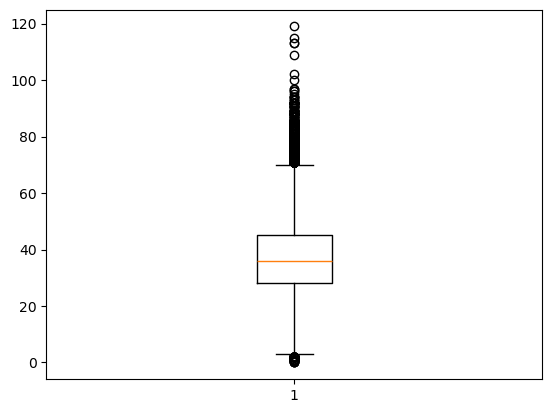

Age_At_Start


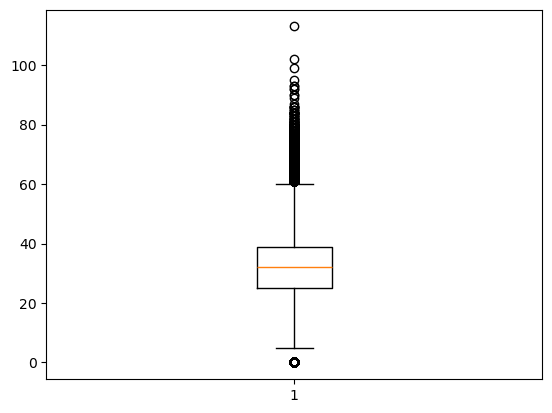

DaysOfARVRefill


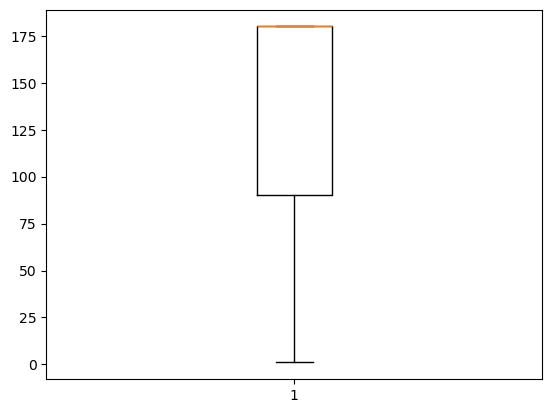

CurrentViralLoad


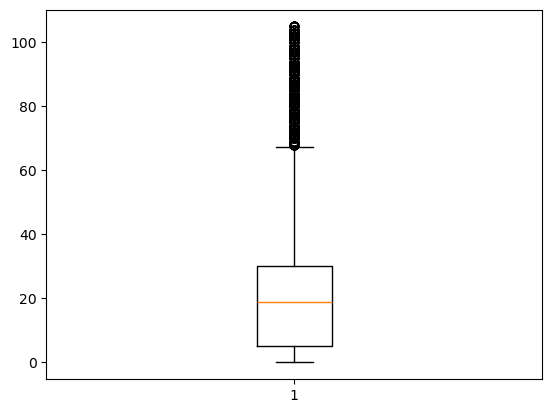

CurrentWeight_Kg


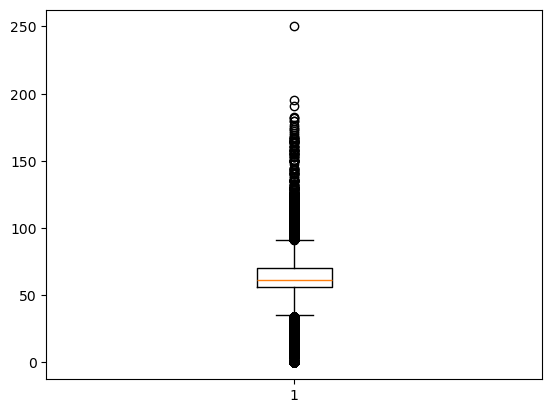

CurrentHeight_cm


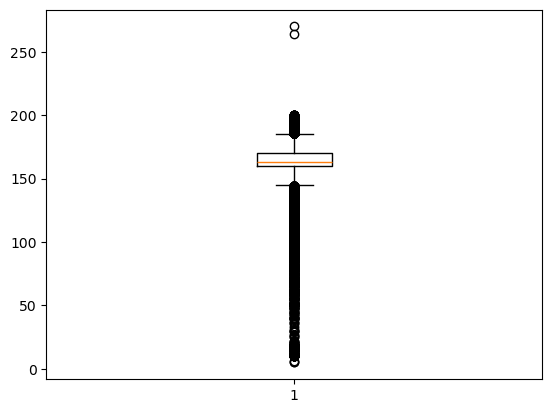

Days_To_Schedule


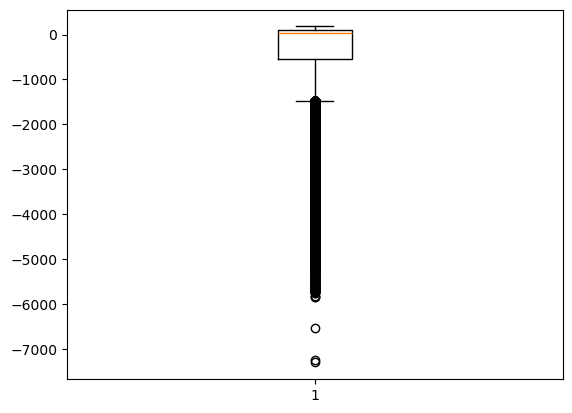

In [15]:
# Check distribution of the numerical variables
for col in data.select_dtypes(['int', 'float']):
    print(col)
    plt.boxplot(data[col])
    plt.show()

In [14]:
# eliminate outlier in current viral load column: implement IQR
#data['CurrentViralLoad']
q1, q3 = np.percentile(data['CurrentViralLoad'], [25, 75])
IQR = q3 - q1

lower_bound = q1 - 3 * IQR
upper_bound = q3 + 3 * IQR

print(lower_bound)
print(upper_bound)

non_outlier_median = data[~(data['CurrentViralLoad'] < lower_bound) | (data['CurrentViralLoad'] > upper_bound)]['CurrentViralLoad'].median()
data.loc[(data['CurrentViralLoad'] < lower_bound) | (data['CurrentViralLoad'] > upper_bound), 'CurrentViralLoad'] = non_outlier_median

-70.0
105.0


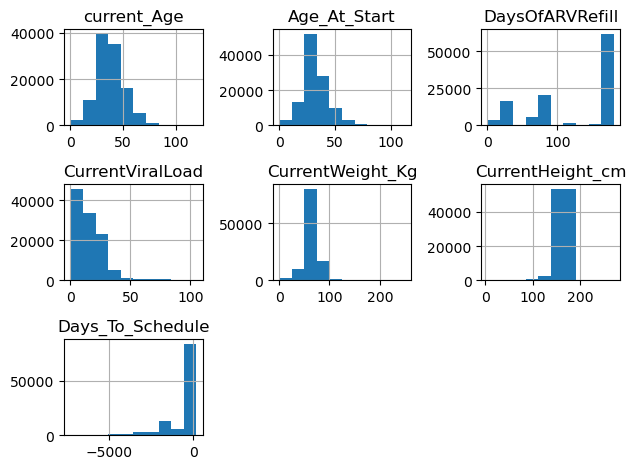

In [16]:
# check distribution of numerical variables 
data.select_dtypes(['int', 'float']).hist()
plt.tight_layout()
plt.show()

## Treating Nulls: Categorical Variables

In [17]:
# Show unique values in categorical features
categorical_features = ['Sex', 'CurrentRegimenLine', 'TBStatus', 'Appointment_Status',
                       'RegimenLineAtARTStart',	'RegimenAtARTStart', 'CurrentARTRegimen', 'ViralLoadIndication', 'DTGFirstPickUp',	
                       'CurrentARTStatus',	'Biometric_Status']
for feature in categorical_features:
    print(f"{data[feature].value_counts()}\n")

Sex
Female    63931
Male      46552
Name: count, dtype: int64

CurrentRegimenLine
Adult 1st line ARV regimen     98205
Child 1st line ARV regimen      1933
Adult 2nd line ARV regimen      1208
Child 2nd line ARV regimen       100
Adult 3rd Line ARV Regimens       27
One                               24
Two                                1
Child 3rd Line ARV Regimens        1
AZT-3TC-DTG                        1
Name: count, dtype: int64

TBStatus
No signs or symptoms of disease    97519
Currently on INH prophylaxis        1460
Disease suspected                   1129
On treatment for disease             269
Completed treatment for disease      251
Disease diagnosed                    105
27-Jul-22                              1
Name: count, dtype: int64

Appointment_Status
Active With Drugs     71483
LTFU                  36481
Missed Appointment     2502
Today Visit              19
Name: count, dtype: int64

RegimenLineAtARTStart
Adult 1st line ARV regimen     98994
Child 1st line ARV

In [18]:
# clean noticeable outiers from the categorical variables. 
data = data[(data['CurrentRegimenLine'] != 'One') | (data['CurrentRegimenLine'] != 'Two' )| (data['CurrentRegimenLine'] != 'AZT-3TC-DTG')]
data = data[data['TBStatus'] != '27-Jul-22']
data = data[(data['RegimenLineAtARTStart'] != 'One') | (data['RegimenLineAtARTStart'] != 'Three') | (data['RegimenLineAtARTStart'] != '30')]

In [19]:
# dealing with null values 
cat_null_value = list(data.select_dtypes(['O']).isnull().sum().index)

In [20]:
# fill with mode according to the mode of each category of the target variable 
for col in cat_null_value: 
    cat_mode = data.groupby('CurrentARTStatus')[col].agg(pd.Series.mode)
    data[col] = data.apply(lambda row: cat_mode[row['CurrentARTStatus']] if pd.isnull(row[col]) else row[col], axis=1)

### Treating Null values: Datetime

In [25]:
datetime_with_null_values = list(data.select_dtypes('datetime64[ns]').isnull().sum().index)
for col in datetime_with_null_values:
    data[col] = data[col].fillna(method = 'ffill')

In [26]:
data.isnull().sum()

ART_ID                        0
Sex                           0
current_Age                   0
Age_At_Start                  0
EnrollmentDate                0
ART_Start_Date                0
Clinic_Visit_Lastdate         0
Pharmacy_LastPickupdate       0
stamp_date                    0
DaysOfARVRefill               0
RegimenLineAtARTStart         0
RegimenAtARTStart             0
CurrentRegimenLine            0
CurrentARTRegimen             0
CurrentViralLoad              0
DateofCurrentViralLoad        0
LastDateOfSampleCollection    0
ViralLoadReportedDate         0
ViralLoadIndication           0
CurrentWeight_Kg              0
CurrentWeightDate             0
CurrentHeight_cm              0
CurrentHeightDate             0
TBStatus                      0
TBStatusDate                  0
INHStartDate                  0
DTGFirstPickUp                0
DateofFirstDTGPickup          0
CurrentARTStatus              0
Appointment_Status            0
Next_Visit_Date               0
Next_Ap_

In [27]:
data

,ART_ID,Sex,current_Age,Age_At_Start,EnrollmentDate,ART_Start_Date,Clinic_Visit_Lastdate,Pharmacy_LastPickupdate,stamp_date,DaysOfARVRefill,...,DateofFirstDTGPickup,CurrentARTStatus,Appointment_Status,Next_Visit_Date,Next_Ap_by_pharmPill,Next_Ap_by_careCard,Days_To_Schedule,Biometric_Status,Biometric_date,Date_Generated
0,(974)501-6883x08492,Male,47.0,42.0,2017-08-03,2017-08-03,2022-03-10,2022-03-10,2022-03-11 12:57:00,180.0,...,2019-08-22,Active,Active With Drugs,2022-09-06,2022-09-06,2022-09-06,12.0,Yes,2021-01-07,2022-08-25 19:25:00
1,+1-810-788-3843x98335,Female,33.0,27.0,2016-06-13,2016-06-13,2016-06-13,2016-06-13,2017-09-28 00:00:00,14.0,...,2019-08-22,LTFU,LTFU,2016-07-13,2022-09-06,2022-09-06,-2234.0,No,2021-01-07,2022-08-25 19:25:00
2,001-293-418-2360,Male,54.0,49.0,2017-06-29,2017-06-29,2022-04-14,2022-04-14,2022-04-14 11:34:00,180.0,...,2017-06-29,Active,Active With Drugs,2022-10-11,2022-10-11,2022-10-11,47.0,Yes,2021-02-04,2022-08-25 19:25:00
3,749.449.7123,Female,35.0,30.0,2017-03-16,2017-03-17,2020-04-28,2020-04-28,2020-05-01 10:37:00,90.0,...,2019-08-15,Death,LTFU,2020-07-27,2022-10-11,2020-07-23,-759.0,No,2021-02-04,2022-08-25 19:25:00
4,001-369-776-0180x4098,Female,67.0,62.0,2017-05-25,2017-05-25,2022-04-28,2022-04-28,2022-04-28 15:34:00,180.0,...,2019-09-26,Active,Active With Drugs,2022-10-25,2022-10-25,2022-10-25,61.0,Yes,2021-05-05,2022-08-25 19:25:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110480,+1-373-746-5342x73107,Male,39.0,30.0,2013-10-02,2013-10-02,2022-08-24,2022-08-24,2022-08-24 15:07:00,90.0,...,2022-08-24,Active,Active With Drugs,2022-11-22,2022-11-22,2022-11-25,85.0,Yes,2022-08-24,2022-08-29 09:58:00
110481,001-930-216-6065x3869,Male,52.0,33.0,2022-05-11,2013-10-02,2022-08-24,2022-08-24,2022-08-24 15:07:00,30.0,...,2022-08-24,LTFU,LTFU,2022-11-22,2022-11-22,2022-11-25,-1942.5,No,2022-08-24,2022-08-29 09:58:00
110482,461.729.8054,Male,37.0,33.0,2022-08-24,2013-10-02,2022-08-24,2022-08-24,2022-08-24 15:07:00,30.0,...,2022-08-24,LTFU,LTFU,2022-11-22,2022-11-22,2022-11-25,-1942.5,Yes,2022-08-25,2022-08-29 09:58:00
110483,+1-548-866-1208x215,Female,32.0,32.0,2022-08-24,2022-08-24,2022-08-24,2022-08-24,2022-08-25 09:38:00,90.0,...,2022-08-24,Active,Active With Drugs,2022-11-22,2022-11-22,2022-11-23,85.0,Yes,2022-08-25,2022-08-29 09:58:00


## Feature Selection

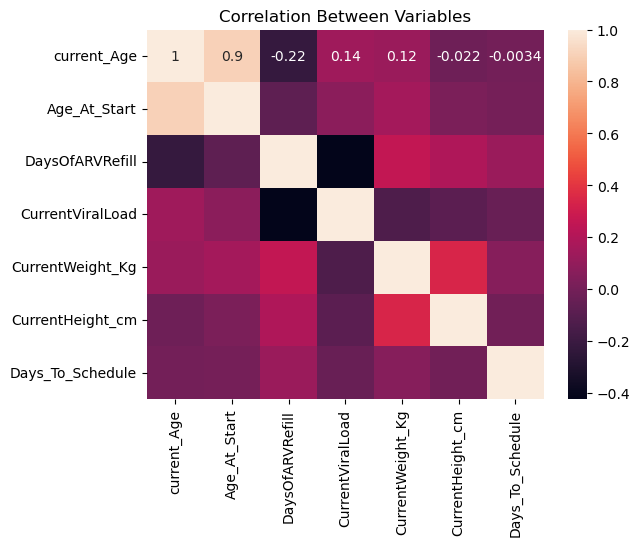

In [119]:
# Check correlation between variables
corr_matrix = data.select_dtypes(['int', 'float']).corr()
sns.heatmap(corr_matrix, annot = True)
plt.title('Correlation Between Variables')
plt.show()

In [47]:
# selection based on intuition
selected_data = data[['Sex', 'current_Age', 'Age_At_Start', 'DaysOfARVRefill', 'RegimenLineAtARTStart',
                      'RegimenAtARTStart', 'CurrentRegimenLine', 'CurrentARTRegimen',
                      'CurrentViralLoad', 'ViralLoadIndication', 'CurrentWeight_Kg', 'CurrentHeight_cm', 'TBStatus',
                      'CurrentARTStatus', 'Appointment_Status', 'Days_To_Schedule',
                      'Biometric_Status']]

In [48]:
# Selection by plotting feature importance using mutual info regression
from sklearn.feature_selection import mutual_info_regression

feature_data = selected_data.copy()
x = feature_data
y = feature_data.pop('CurrentARTStatus')

# Encoding Categorical variables
for col in feature_data.select_dtypes(['object', 'category']):
    x[col],_ = x[col].factorize()

# Encoding y variable
y,_ = y.factorize()

Text(0.5, 1.0, 'Feature Importance')

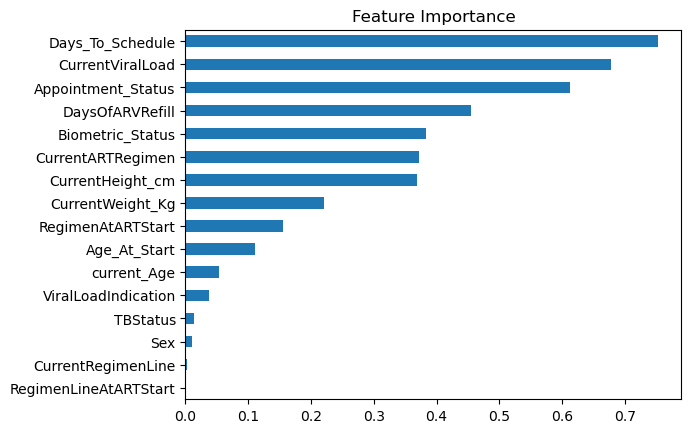

In [52]:
# Build Mutual Regression Model
#x = x.select_dtypes('int64')
mi_scores = mutual_info_regression(x,y, random_state = 42)
mi_scores = pd.Series(mi_scores, index = x.columns)
best_features = mi_scores.sort_values(ascending = False)

# Show features relationship to target variable
best_features.sort_values(ascending = True).plot(kind = 'barh')
plt.title('Feature Importance')

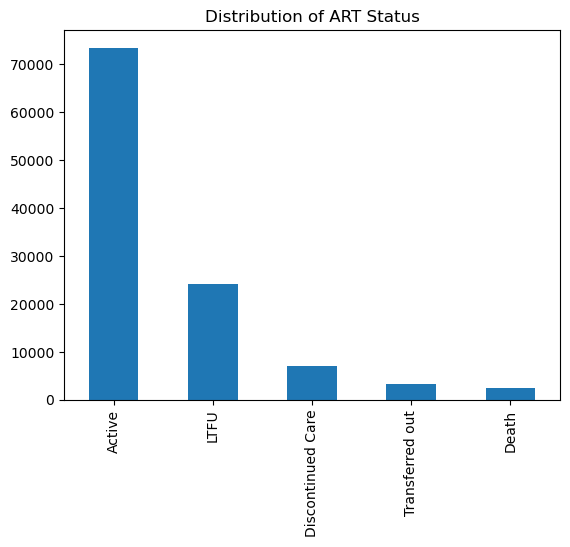

In [53]:
#plot distribution of categorical variable
data['CurrentARTStatus'].value_counts().plot.bar()
plt.title('Distribution of ART Status')
plt.xlabel('')
plt.show()

### Feature Encoding

In [56]:
# show cardinality count
print('This counts number of unique value in the categorical variable\n')
for col in selected_data.select_dtypes('O'):
    print(f"{col} : {selected_data[col].value_counts().nunique()}\n")

This counts number of unique value in the categorical variable

Sex : 2

RegimenLineAtARTStart : 7

RegimenAtARTStart : 29

CurrentRegimenLine : 7

CurrentARTRegimen : 28

ViralLoadIndication : 7

TBStatus : 6

CurrentARTStatus : 5

Appointment_Status : 4

Biometric_Status : 2



In [57]:
# Encode Sex and Biometric_Status using binary encoding method
pred_data = selected_data.copy()
encoder = BinaryEncoder()
pred_data[['Sex_Female','Sex_Male',	'Biometric_Status_No','Biometric_Status_Yes']] = encoder.fit_transform(pred_data[['Sex', 'Biometric_Status']])

In [60]:
# Encode selected columns using get_dummies - one hot encoding technique
pred_data_encoded= pd.get_dummies(pred_data, columns=['RegimenLineAtARTStart', 'TBStatus', 'ViralLoadIndication', 
                                                      'CurrentRegimenLine', 'Appointment_Status'])
pred_data_encoded

,Sex,current_Age,Age_At_Start,DaysOfARVRefill,RegimenAtARTStart,CurrentARTRegimen,CurrentViralLoad,CurrentWeight_Kg,CurrentHeight_cm,CurrentARTStatus,...,CurrentRegimenLine_Adult 3rd Line ARV Regimens,CurrentRegimenLine_Child 1st line ARV regimen,CurrentRegimenLine_Child 2nd line ARV regimen,CurrentRegimenLine_Child 3rd Line ARV Regimens,CurrentRegimenLine_One,CurrentRegimenLine_Two,Appointment_Status_Active With Drugs,Appointment_Status_LTFU,Appointment_Status_Missed Appointment,Appointment_Status_Today Visit
0,Male,47.0,42.0,180.0,AZT-3TC-NVP,TDF-3TC-DTG,19.0,95.0,170.0,Active,...,False,False,False,False,False,False,True,False,False,False
1,Female,33.0,27.0,14.0,TDF-3TC-EFV,TDF-3TC-EFV,30.0,56.0,161.0,LTFU,...,False,False,False,False,False,False,False,True,False,False
2,Male,54.0,49.0,180.0,AZT-3TC-NVP,TDF-3TC-DTG,19.0,80.0,160.0,Active,...,False,False,False,False,False,False,True,False,False,False
3,Female,35.0,30.0,90.0,TDF-3TC-EFV,TDF-3TC-DTG,19.0,40.0,162.0,Death,...,False,False,False,False,False,False,False,True,False,False
4,Female,67.0,62.0,180.0,AZT-3TC-NVP,TDF-3TC-DTG,0.0,77.0,165.0,Active,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110480,Male,39.0,30.0,90.0,TDF-3TC-EFV,TDF-3TC-DTG,10.0,49.0,162.0,Active,...,False,False,False,False,False,False,True,False,False,False
110481,Male,52.0,33.0,30.0,TDF-3TC-EFV,TDF-3TC-EFV,30.0,56.0,161.0,LTFU,...,False,False,False,False,False,False,False,True,False,False
110482,Male,37.0,33.0,30.0,TDF-3TC-EFV,TDF-3TC-EFV,30.0,56.0,161.0,LTFU,...,False,False,False,False,False,False,False,True,False,False
110483,Female,32.0,32.0,90.0,TDF-3TC-DTG,TDF-3TC-DTG,10.0,62.0,155.0,Active,...,False,False,False,False,False,False,True,False,False,False


In [61]:
# calculate frequency of each category and encode using those frequencies - Frequency Encoding 
regimen_at_start_freq = pred_data_encoded['RegimenAtARTStart'].value_counts(normalize=True)
current_art_regimen_freq = pred_data_encoded['CurrentARTRegimen'].value_counts(normalize=True)

# Replace categories with frequencies
pred_data_encoded['RegimenAtARTStart'] = pred_data_encoded['RegimenAtARTStart'].map(regimen_at_start_freq)
pred_data_encoded['CurrentARTRegimen'] = pred_data_encoded['CurrentARTRegimen'].map(current_art_regimen_freq)

In [62]:
pred_data_encoded

,Sex,current_Age,Age_At_Start,DaysOfARVRefill,RegimenAtARTStart,CurrentARTRegimen,CurrentViralLoad,CurrentWeight_Kg,CurrentHeight_cm,CurrentARTStatus,...,CurrentRegimenLine_Adult 3rd Line ARV Regimens,CurrentRegimenLine_Child 1st line ARV regimen,CurrentRegimenLine_Child 2nd line ARV regimen,CurrentRegimenLine_Child 3rd Line ARV Regimens,CurrentRegimenLine_One,CurrentRegimenLine_Two,Appointment_Status_Active With Drugs,Appointment_Status_LTFU,Appointment_Status_Missed Appointment,Appointment_Status_Today Visit
0,Male,47.0,42.0,180.0,0.089968,0.759042,19.0,95.0,170.0,Active,...,False,False,False,False,False,False,True,False,False,False
1,Female,33.0,27.0,14.0,0.256951,0.150130,30.0,56.0,161.0,LTFU,...,False,False,False,False,False,False,False,True,False,False
2,Male,54.0,49.0,180.0,0.089968,0.759042,19.0,80.0,160.0,Active,...,False,False,False,False,False,False,True,False,False,False
3,Female,35.0,30.0,90.0,0.256951,0.759042,19.0,40.0,162.0,Death,...,False,False,False,False,False,False,False,True,False,False
4,Female,67.0,62.0,180.0,0.089968,0.759042,0.0,77.0,165.0,Active,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110480,Male,39.0,30.0,90.0,0.256951,0.759042,10.0,49.0,162.0,Active,...,False,False,False,False,False,False,True,False,False,False
110481,Male,52.0,33.0,30.0,0.256951,0.150130,30.0,56.0,161.0,LTFU,...,False,False,False,False,False,False,False,True,False,False
110482,Male,37.0,33.0,30.0,0.256951,0.150130,30.0,56.0,161.0,LTFU,...,False,False,False,False,False,False,False,True,False,False
110483,Female,32.0,32.0,90.0,0.584130,0.759042,10.0,62.0,155.0,Active,...,False,False,False,False,False,False,True,False,False,False


In [63]:
# drop Sex column
pred_data_encoded = pred_data_encoded.drop(['Sex', 'Biometric_Status'], axis = 1)

In [65]:
# replace True and False values with 1 and 0
pred_data_encoded.replace({True: 1, False: 0}, inplace=True)

In [67]:
# deal with column headers
pred_data_encoded.columns = pred_data_encoded.columns.str.replace(' ', '_', regex=False)
pred_data_encoded.rename(columns = {'ViralLoadIndication_Normal_priority_(status)': 'ViralLoadIndication_Normal_priority_status'}, inplace = True)
pred_data_encoded.columns

Index(['current_Age', 'Age_At_Start', 'DaysOfARVRefill', 'RegimenAtARTStart',
       'CurrentARTRegimen', 'CurrentViralLoad', 'CurrentWeight_Kg',
       'CurrentHeight_cm', 'CurrentARTStatus', 'Days_To_Schedule',
       'Biometric_Status', 'Sex_Female', 'Sex_Male', 'Biometric_Status_No',
       'Biometric_Status_Yes',
       'RegimenLineAtARTStart_Adult_1st_line_ARV_regimen',
       'RegimenLineAtARTStart_Adult_2nd_line_ARV_regimen',
       'RegimenLineAtARTStart_Adult_3rd_Line_ARV_Regimens',
       'RegimenLineAtARTStart_Child_1st_line_ARV_regimen',
       'RegimenLineAtARTStart_Child_2nd_line_ARV_regimen',
       'RegimenLineAtARTStart_One', 'RegimenLineAtARTStart_Three',
       'TBStatus_Completed_treatment_for_disease',
       'TBStatus_Currently_on_INH_prophylaxis', 'TBStatus_Disease_diagnosed',
       'TBStatus_Disease_suspected',
       'TBStatus_No_signs_or_symptoms_of_disease',
       'TBStatus_On_treatment_for_disease',
       'ViralLoadIndication_Clinical_failure',
       'V

In [118]:
pred_data_encoded

,current_Age,Age_At_Start,DaysOfARVRefill,RegimenAtARTStart,CurrentARTRegimen,CurrentViralLoad,CurrentWeight_Kg,CurrentHeight_cm,CurrentARTStatus,Days_To_Schedule,...,CurrentRegimenLine_Adult_3rd_Line_ARV_Regimens,CurrentRegimenLine_Child_1st_line_ARV_regimen,CurrentRegimenLine_Child_2nd_line_ARV_regimen,CurrentRegimenLine_Child_3rd_Line_ARV_Regimens,CurrentRegimenLine_One,CurrentRegimenLine_Two,Appointment_Status_Active_With_Drugs,Appointment_Status_LTFU,Appointment_Status_Missed_Appointment,Appointment_Status_Today_Visit
0,47.0,42.0,180.0,0.089968,0.759042,19.0,95.0,170.0,Active,12.0,...,0,0,0,0,0,0,1,0,0,0
1,33.0,27.0,14.0,0.256951,0.150130,30.0,56.0,161.0,LTFU,-2234.0,...,0,0,0,0,0,0,0,1,0,0
2,54.0,49.0,180.0,0.089968,0.759042,19.0,80.0,160.0,Active,47.0,...,0,0,0,0,0,0,1,0,0,0
3,35.0,30.0,90.0,0.256951,0.759042,19.0,40.0,162.0,Death,-759.0,...,0,0,0,0,0,0,0,1,0,0
4,67.0,62.0,180.0,0.089968,0.759042,0.0,77.0,165.0,Active,61.0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110480,39.0,30.0,90.0,0.256951,0.759042,10.0,49.0,162.0,Active,85.0,...,0,0,0,0,0,0,1,0,0,0
110481,52.0,33.0,30.0,0.256951,0.150130,30.0,56.0,161.0,LTFU,-1942.5,...,0,0,0,0,0,0,0,1,0,0
110482,37.0,33.0,30.0,0.256951,0.150130,30.0,56.0,161.0,LTFU,-1942.5,...,0,0,0,0,0,0,0,1,0,0
110483,32.0,32.0,90.0,0.584130,0.759042,10.0,62.0,155.0,Active,85.0,...,0,0,0,0,0,0,1,0,0,0


In [122]:
# Save data
pred_data_encoded.to_csv('new_ART_data.csv', index = False)

### Model_building

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [77]:
ART_data

,current_Age,Age_At_Start,DaysOfARVRefill,RegimenAtARTStart,CurrentARTRegimen,CurrentViralLoad,CurrentWeight_Kg,CurrentHeight_cm,Days_To_Schedule,Sex_Female,...,CurrentRegimenLine_Adult_3rd_Line_ARV_Regimens,CurrentRegimenLine_Child_1st_line_ARV_regimen,CurrentRegimenLine_Child_2nd_line_ARV_regimen,CurrentRegimenLine_Child_3rd_Line_ARV_Regimens,CurrentRegimenLine_One,CurrentRegimenLine_Two,Appointment_Status_Active_With_Drugs,Appointment_Status_LTFU,Appointment_Status_Missed_Appointment,Appointment_Status_Today_Visit
0,47.0,42.0,180.0,0.089968,0.759042,19.0,95.0,170.0,12.0,0,...,0,0,0,0,0,0,1,0,0,0
1,33.0,27.0,14.0,0.256951,0.150130,30.0,56.0,161.0,-2234.0,1,...,0,0,0,0,0,0,0,1,0,0
2,54.0,49.0,180.0,0.089968,0.759042,19.0,80.0,160.0,47.0,0,...,0,0,0,0,0,0,1,0,0,0
3,35.0,30.0,90.0,0.256951,0.759042,19.0,40.0,162.0,-759.0,1,...,0,0,0,0,0,0,0,1,0,0
4,67.0,62.0,180.0,0.089968,0.759042,0.0,77.0,165.0,61.0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110480,39.0,30.0,90.0,0.256951,0.759042,10.0,49.0,162.0,85.0,0,...,0,0,0,0,0,0,1,0,0,0
110481,52.0,33.0,30.0,0.256951,0.150130,30.0,56.0,161.0,-1942.5,0,...,0,0,0,0,0,0,0,1,0,0
110482,37.0,33.0,30.0,0.256951,0.150130,30.0,56.0,161.0,-1942.5,0,...,0,0,0,0,0,0,0,1,0,0
110483,32.0,32.0,90.0,0.584130,0.759042,10.0,62.0,155.0,85.0,1,...,0,0,0,0,0,0,1,0,0,0


In [76]:
# Separate into independent and response variable
ART_data = pred_data_encoded.copy()
x = ART_data
y = ART_data.pop('CurrentARTStatus')

In [78]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Model Selection
models = {
    'Logistic_Regression': LogisticRegression(),
    'Decision_Tree': DecisionTreeClassifier(),
    'Random_Forest': RandomForestClassifier(),
    'Gradient_Boosting': GradientBoostingClassifier()
}

# Model Training and Evaluation
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

Logistic_Regression Classification Report:
                   precision    recall  f1-score   support

           Active       0.99      1.00      0.99     14784
            Death       0.36      0.11      0.16       490
Discontinued Care       0.63      0.67      0.65      1425
             LTFU       0.85      0.94      0.89      4785
  Transferred out       0.35      0.11      0.17       613

         accuracy                           0.92     22097
        macro avg       0.64      0.56      0.57     22097
     weighted avg       0.90      0.92      0.91     22097

[[14776     5     1     2     0]
 [   26    52    75   312    25]
 [   33    27   956   355    54]
 [  100    39   116  4488    42]
 [   42    20   375   110    66]]
Decision_Tree Classification Report:
                   precision    recall  f1-score   support

           Active       1.00      0.99      0.99     14784
            Death       0.75      0.72      0.73       490
Discontinued Care       0.78      0.79    

### Fit Random Forest with different hyperparameters

In [96]:
# Fit model
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

RandomForestClassifier()

In [117]:
feature_importance = {}
importance = random_forest.feature_importances_
indices = np.argsort(importance)[::-1]
for f in range(X_train.shape[1]):
    feature_name = X_train.columns[indices[f]]
    importance_value = importance[indices[f]]
    feature_importance[feature_name] = importance_value

fi_data = list(feature_importance.items())
feature_importance_df = pd.DataFrame(fi_data, columns=['Feature', 'Importance'])
feature_importance_df

,Feature,Importance
0,Days_To_Schedule,1.980665e-01
1,CurrentViralLoad,1.329758e-01
2,Appointment_Status_LTFU,1.283040e-01
3,Appointment_Status_Active_With_Drugs,1.049099e-01
4,DaysOfARVRefill,8.209571e-02
5,CurrentARTRegimen,6.774847e-02
6,CurrentHeight_cm,5.442669e-02
7,Biometric_Status_Yes,5.169035e-02
8,Biometric_Status_No,4.655436e-02
9,CurrentWeight_Kg,4.175115e-02


## Implementing SMOTE in the under sampled response variable

In [82]:
from imblearn.over_sampling import SMOTE

In [88]:
#majority_class = max(y_train.value_counts().index)
#num_samples_majority = len(y_train[y_train == majority_class])

# Create a sampling strategy dictionary
#sampling_strategy = {'Active': num_samples_majority} 
sm = SMOTE(random_state = 42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [90]:
y_train_res.value_counts()

CurrentARTStatus
Active               58703
LTFU                 58703
Transferred out      58703
Death                58703
Discontinued Care    58703
Name: count, dtype: int64

In [91]:
# Train a model
random_forest_res = RandomForestClassifier()
random_forest_res.fit(X_train, y_train)

RandomForestClassifier()

In [92]:
ypred = random_forest_res.predict(X_test)

In [95]:
print(classification_report(y_test, ypred))
print(confusion_matrix(y_test, ypred))

                   precision    recall  f1-score   support

           Active       0.99      1.00      1.00     14784
            Death       0.81      0.72      0.76       490
Discontinued Care       0.83      0.83      0.83      1425
             LTFU       0.97      0.98      0.97      4785
  Transferred out       0.58      0.52      0.55       613

         accuracy                           0.96     22097
        macro avg       0.84      0.81      0.82     22097
     weighted avg       0.96      0.96      0.96     22097

[[14784     0     0     0     0]
 [   23   351    28    42    46]
 [   21    31  1178    52   143]
 [   13    19    31  4682    40]
 [   28    35   178    54   318]]


### Save Model


In [120]:
import pickle

In [121]:
with open('new_ART_RF_Model.pkl', 'wb') as f:
    pickle.dump(random_forest_res, f)